# Classification Downstream Task 

In [18]:
import math
from typing import List
from datetime import datetime

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch import optim
from tqdm import tqdm
from sklearn.metrics import classification_report


from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset

## Neural Network Model Definition ## 

In [2]:
class EncoderBlock(nn.Module):
    """
    Model used for ML-Challenge
    """

    def __init__(self):
        """
        Model definition
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 5)  # in: 3x64x64 out: 60x60x24
        self.pool = nn.MaxPool2d(2, 2)  # out: 30x30x24
        self.conv2 = nn.Conv2d(24, 72, 5)  # out: 26x26x72

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        return x


class FullyConnectedBlock(nn.Module):
    """
    Model used for ML-Challenge
    """

    def __init__(self, input_dim: int):
        """
        Model definition
        """
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)  # 72 * 13 * 13
        self.fc2 = nn.Linear(512, 124)
        self.fc3 = nn.Linear(124, 10)

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DownstreamNet(nn.Module):
    """
    Model used for ML-Challenge
    """

    def __init__(self, input_dim: int, encoder=None):
        """
        Model definition
        """
        super().__init__()
        self.encoder = encoder if encoder else EncoderBlock()
        self.fc = FullyConnectedBlock(input_dim=input_dim)

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = self.encoder(x)
        x = self.fc(x)
        return x

## Dataset Loading ##

In [9]:
eurosat_ds = EuroSAT(root="./", download=True, transform=T.ToTensor())

# Creating data indices for training and validation splits:
random_seed = 42
dataset_size = len(eurosat_ds)
indices = list(range(dataset_size))
test_split_ratio = 0.2
split = int(np.floor(test_split_ratio * dataset_size))

# Shuffle dataset
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [10]:
train_dl = DataLoader(
    dataset=eurosat_ds,
    batch_size=128,
    sampler=train_sampler,
)

test_dl = DataLoader(
    dataset=eurosat_ds,
    batch_size=128,
    sampler=test_sampler,
)

## Model Training ##


In [11]:
# First of all, let's verify if a GPU is available on our compute machine. If not, the cpu will be used instead.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device used: {}".format(device))

Device used: cuda:0


In [12]:
model = DownstreamNet(input_dim=72 * 13 * 13).to(device)

# define the optimization criterion / loss function
loss_criterion = nn.CrossEntropyLoss().to(device)

# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
model

DownstreamNet(
  (encoder): EncoderBlock(
    (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(24, 72, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc): FullyConnectedBlock(
    (fc1): Linear(in_features=12168, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=124, bias=True)
    (fc3): Linear(in_features=124, out_features=10, bias=True)
  )
)

In [14]:
# specify the training parameters
num_epochs = 10  # number of training epochs
train_epoch_losses = []
validation_epoch_losses = []


for epoch in range(num_epochs):
    model.train()
    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in tqdm(enumerate(train_dl), total=len(train_dl)):

        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        optimizer.zero_grad()
        out = model(images)
        loss = loss_criterion(out, labels)
        loss.backward()
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)

    # Specify you are in evaluation mode
    model.eval()
    with torch.no_grad():
        validation_mini_batch_losses = []
        for (images, labels) in test_dl:
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            validation_epoch_loss = loss_criterion(outputs, labels)
            # collect mini-batch reconstruction loss
            validation_mini_batch_losses.append(loss.data.item())
        validation_epoch_loss = np.mean(validation_mini_batch_losses)
        validation_epoch_losses.append(validation_epoch_loss)

    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print(
        f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss} validation-loss: {validation_epoch_loss}"
    )

100%|██████████| 169/169 [00:15<00:00, 11.11it/s]


[LOG 20221027-13:33:44] epoch: 1 train-loss: 1.480928829435766 validation-loss: 1.2402197122573853


100%|██████████| 169/169 [00:12<00:00, 13.25it/s]


[LOG 20221027-13:33:59] epoch: 2 train-loss: 1.0071332916705567 validation-loss: 0.8630091547966003


100%|██████████| 169/169 [00:13<00:00, 12.65it/s]


[LOG 20221027-13:34:14] epoch: 3 train-loss: 0.7849056743658506 validation-loss: 0.7523846626281738


100%|██████████| 169/169 [00:12<00:00, 13.11it/s]


[LOG 20221027-13:34:30] epoch: 4 train-loss: 0.6741639231083661 validation-loss: 0.7110217213630676


100%|██████████| 169/169 [00:13<00:00, 12.81it/s]


[LOG 20221027-13:34:45] epoch: 5 train-loss: 0.6494043100867751 validation-loss: 0.5024420619010925


100%|██████████| 169/169 [00:12<00:00, 13.26it/s]


[LOG 20221027-13:35:00] epoch: 6 train-loss: 0.5615866159546304 validation-loss: 0.5328946113586426


100%|██████████| 169/169 [00:12<00:00, 13.33it/s]


[LOG 20221027-13:35:16] epoch: 7 train-loss: 0.5410281814767058 validation-loss: 0.7607574462890625


100%|██████████| 169/169 [00:12<00:00, 13.21it/s]


[LOG 20221027-13:35:31] epoch: 8 train-loss: 0.479756369745943 validation-loss: 0.3574117422103882


100%|██████████| 169/169 [00:16<00:00, 10.32it/s]


[LOG 20221027-13:35:51] epoch: 9 train-loss: 0.44355890243011115 validation-loss: 0.48850345611572266


100%|██████████| 169/169 [00:13<00:00, 12.76it/s]


[LOG 20221027-13:36:07] epoch: 10 train-loss: 0.40241120023840277 validation-loss: 0.3943125307559967


## Model Evaluation ##

In [15]:
def visualize_losses_during_training(
    train_epoch_losses: List[float], validation_epoch_losses: List[float]
) -> None:
    """
    Visualizes losses gathered during training.
    :param train_epoch_losses: List containing training loss per epoch
    :param validation_epoch_losses: List containing validation loss per epoch
    :return: None
    """
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # add grid
    ax.grid(linestyle="dotted")

    # plot the training epochs vs. the epochs' classification error
    ax.plot(
        np.array(range(1, len(train_epoch_losses) + 1)),
        train_epoch_losses,
        label="epoch train. loss (blue)",
    )
    ax.plot(
        np.array(range(1, len(validation_epoch_losses) + 1)),
        validation_epoch_losses,
        label="epoch val. loss (blue)",
    )
    # add axis legends
    ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
    ax.set_ylabel("[Classification Error $\\mathcal{L}^{CE}$]", fontsize=10)

    # set plot legend
    plt.legend(loc="upper right", numpoints=1, fancybox=True)

    # add plot title
    plt.title("Training Epochs $e_i$ vs. Classification Error $L^{CE}$", fontsize=10)

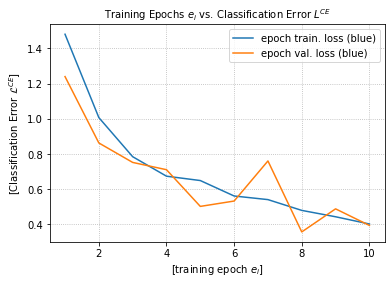

In [16]:
visualize_losses_during_training(train_epoch_losses, validation_epoch_losses)

In [22]:
y_pred = []
y_true = []
# iterate over test data
model.eval()
with torch.no_grad():
    for (images, labels) in tqdm(test_dl, desc="Predict labels"):
        images = images.to(device)

        outputs = model(images)  # Feed Network
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())  # Save Prediction
        y_true.extend(labels.numpy())  # Save Truth

Predict labels: 100%|██████████| 43/43 [00:02<00:00, 17.45it/s]


In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84       595
           1       0.84      0.92      0.88       606
           2       0.80      0.72      0.76       602
           3       0.69      0.56      0.62       515
           4       0.83      0.97      0.89       493
           5       0.75      0.75      0.75       423
           6       0.65      0.73      0.69       473
           7       0.91      0.96      0.93       597
           8       0.61      0.79      0.69       490
           9       0.98      0.78      0.87       606

    accuracy                           0.80      5400
   macro avg       0.80      0.79      0.79      5400
weighted avg       0.81      0.80      0.80      5400

